In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import keras_tuner

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
SEED = 42
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(SEED)

<h3>Callbacks</h3>

In [3]:
# EarlyStop, patience means how it waits before deciding if stopping is needed
es = EarlyStopping(monitor='val_loss', patience=100, mode="min")

# when sweet spot / convergence seems to happen, start reducing learning rate
# in order to avoid overfitting. commonly used with EarlyStop
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=20, min_lr=0.0005)

# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)

callback_list = [es,reduce_lr]

In [4]:
# Loading already optimez dataset from Advanced data analytics course
df = pd.read_csv('clean_telecom.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
df.head()

,seniorcitizen,tenure,multiplelines,internetservice,contract,paperlessbilling,monthlycharges,churn,service_count,family,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check
0,0,1,0,1,1,1,29.85,0,1,1,0,0,1
1,0,34,0,1,2,0,56.95,0,2,0,0,0,0
2,0,2,0,1,1,1,53.85,1,2,0,0,0,0
3,0,45,0,1,2,0,42.30,0,3,0,1,0,0
4,0,2,0,2,1,1,70.70,1,0,0,0,0,1


In [6]:
# everything else except target variable
X = df.drop("churn", axis=1)
# only target variable

y_temp = df['churn']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

# Split to 70% for training data and 30% for validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Split the rest 30% for 15% validation and 15% training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
# save the categories into a list
categories = list(np.unique(df['churn']))
print(len(categories))

2


In [8]:
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(8, activation="relu", kernel_regularizer=keras.regularizers.L1L2(l1=0.2, l2=0.2)),
        layers.Dropout(rate=0.1),
        layers.Dense(4, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.9/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198 (792.00 B)

 Trainable params: 174 (696.00 B)

 Non-trainable params: 24 (96.00 B)

In [9]:
model.fit(x=X_train, y=y_train, epochs=800, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/800
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5502 - loss: 6.0462 - val_accuracy: 0.7435 - val_loss: 3.4386 - learning_rate: 0.0010
Epoch 2/800
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.7525 - loss: 2.8603 - val_accuracy: 0.7435 - val_loss: 1.5122 - learning_rate: 0.0010
Epoch 3/800
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.7511 - loss: 1.2624 - val_accuracy: 0.7435 - val_loss: 0.7402 - learning_rate: 0.0010
Epoch 4/800
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.7511 - loss: 0.6824 - val_accuracy: 0.7435 - val_loss: 0.5605 - learning_rate: 0.0010
Epoch 5/800
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.7511 - loss: 0.5523 - val_accuracy: 0.7435 - val_loss: 0.5265 - learning_rate: 0.0010
Epoch 6/800
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.7511 - loss: 0.5341 - val_accuracy: 0.7435 - val_loss: 0.5062 - learning_rate: 0.0010
Epoch 7/800
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.751

<Axes: >

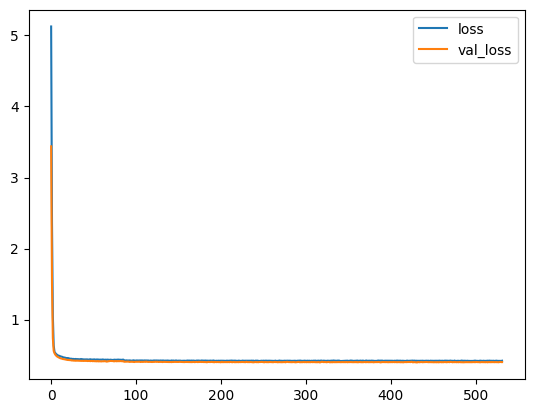

In [10]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

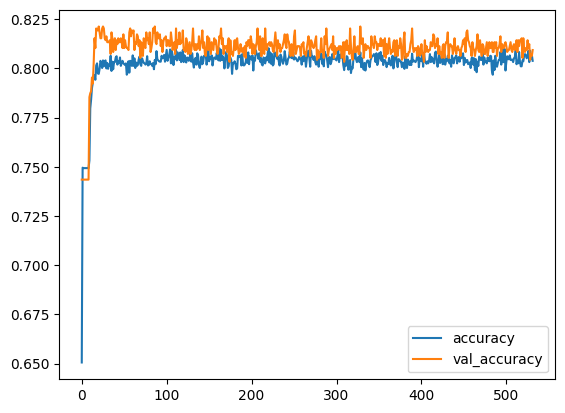

In [11]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [12]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.42641860246658325, 0.7944111824035645]

Train data evaluation:
[0.3990563452243805, 0.8182206749916077]


In [13]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Axes: >

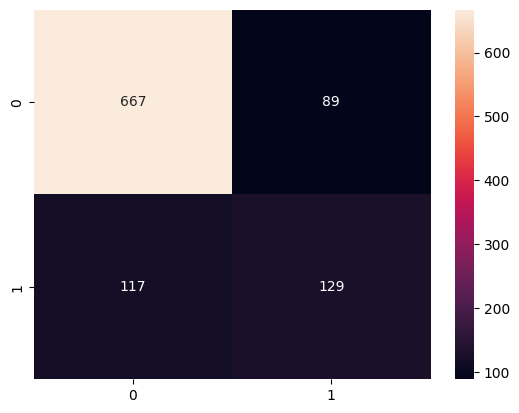

In [14]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [15]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       756
           1       0.59      0.52      0.56       246

    accuracy                           0.79      1002
   macro avg       0.72      0.70      0.71      1002
weighted avg       0.79      0.79      0.79      1002


Model overall accuracy: 79.44%


In [16]:
# get ROC-AUC -score
roc_auc_score(y, model.predict(X))

209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


0.8629377488183458

Standart scale didn't work, roc auc went down to 0.52

Dropout layer increased accuracy of predicted minority


Adding more layers no particular result

With normalization layer model starts to make mistakes with predicting majority, but on the other hand predicts minority with more confidence.

Same goes for L1L2 regularizer

# TODO try sampling technics, keras tuner (especially learning rate), finish formatting
